In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim
import os
import copy
import cv2
from IPython.display import Image 
from google.colab.patches import cv2_imshow
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from skimage import io, transform
from PIL import Image, ImageOps
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [3]:
#this data loading code runs for samarth

train_image_path = './drive/My Drive/AML_assignments/Train_images/Images/'
train_mask_path = './drive/My Drive/AML_assignments/Train_masks/Contours_black/'
validation_image_path = './drive/My Drive/AML_assignments/Test_images/set1/'
validation_mask_path = './drive/My Drive/AML_assignments/Test_masks/Contours_black_test1set/'

# #this data loading code runs for varsha 
# train_image_path = './drive/My Drive/IITB_assignments/AML_assignments/Train_images/Images/'
# train_mask_path = './drive/My Drive/IITB_assignments/AML_assignments/Train_masks/Contours_grey/'
# validation_image_path = './drive/My Drive/IITB_assignments/AML_assignments/Test_images/set1/'
# validation_mask_path = './drive/My Drive/IITB_assignments/AML_assignments/Test_masks/Contours_grey_test1set/'

batch_size = 16
num_epochs = 100

In [4]:
# Model definition

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):
    def __init__(self):
        super().__init__()                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)        
        self.conv_last = nn.Conv2d(64,1, 1)
        self.sig_act = nn.Sigmoid()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)        
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)         
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = self.sig_act(out)
        return out

def unet(pretrained=False, progress=True, **kwargs):
    model = UNet(**kwargs)
    return model

In [5]:
# Initialize the model for this run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = unet()

# send model to device-cuda
model_ft = model_ft.to(device)

# Print the model we just instantiated
print(model_ft)

#Summary of the model
from torchsummary import summary
y = (1,216,216) #works for (216,256) too
summary(model_ft, y)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [5]:
class RV_Data_train(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = train_image_path
        mask_path = train_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

In [6]:
class RV_Data_valid(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = validation_image_path
        mask_path = validation_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

In [7]:
# train data generator
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}
transform = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
                                   ]) 
training_set = RV_Data_train(train_image_path,transform)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [9]:
print('Length of train dataset is:', len(training_set))
print('Length of train dataloader is:', len(training_generator))

Length of train dataset is: 243
Length of train dataloader is: 16


In [8]:
#validation data generator

validation_set = RV_Data_valid(validation_image_path,transform)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [11]:
print('Length of validation dataset is:', len(validation_set))
print('Length of validation dataloader is:', len(validation_generator))

Length of validation dataset is: 262
Length of validation dataloader is: 17


In [ ]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
 
        return (1 - dice_loss)

In [ ]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
#PyTorch
ALPHA = 0.25
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
#PyTorch
class DiceBCEInvLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCEInvLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        inv_intersection = ((1-inputs)*(1-targets)).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        inv_dice_loss = 1 - (2.*inv_intersection + smooth)/((1 - inputs.sum()) + (1 - targets.sum()) + smooth)
        Dice_BCE_inv = BCE + dice_loss + inv_dice_loss
        
        return Dice_BCE_inv

In [9]:
#PyTorch
class SwitchLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SwitchLoss, self).__init__()

    def forward(self, inputs, targets, weight, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)    
        # inputs = (inputs>0.5).float() 
        # targets = (targets>0.5).float()
        mean = torch.mean(targets)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        inv_intersection = ((1-inputs)*(1-targets)).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        inv_dice_loss = 1 - (2.*inv_intersection + smooth)/((1 - inputs).sum() + (1 - targets).sum() + smooth)
        
        if mean>0.5:
          Switch_loss = BCE + (weight*dice_loss) + ((1-weight)*inv_dice_loss)
        else:
          Switch_loss = BCE + ((1 - weight)*dice_loss) + (weight*inv_dice_loss)
                
        return Switch_loss

In [ ]:
criterion = SwitchLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr = 0.00005)

Lambda Value 0.25
Epoch 0/99
----------
Train Loss: 1.4018 
Validation Loss: 1.3961 
Time taken for one epoch 3m 39s
Epoch 1/99
----------
Train Loss: 1.2469 
Validation Loss: 1.0651 
Time taken for one epoch 3m 58s
Epoch 2/99
----------
Train Loss: 1.0324 
Validation Loss: 0.9673 
Time taken for one epoch 4m 16s
Epoch 3/99
----------
Train Loss: 0.9739 
Validation Loss: 0.9172 
Time taken for one epoch 4m 35s
Epoch 4/99
----------
Train Loss: 0.9103 
Validation Loss: 0.8549 
Time taken for one epoch 4m 53s
Epoch 5/99
----------
Train Loss: 0.8636 
Validation Loss: 0.8237 
Time taken for one epoch 5m 12s
Epoch 6/99
----------
Train Loss: 0.8437 
Validation Loss: 0.8161 
Time taken for one epoch 5m 31s
Epoch 7/99
----------
Train Loss: 0.8355 
Validation Loss: 0.8100 
Time taken for one epoch 5m 49s
Epoch 8/99
----------
Train Loss: 0.8196 
Validation Loss: 0.7912 
Time taken for one epoch 6m 8s
Epoch 9/99
----------
Train Loss: 0.8102 
Validation Loss: 0.7813 
Time taken for one epoch 

<Figure size 432x288 with 0 Axes>

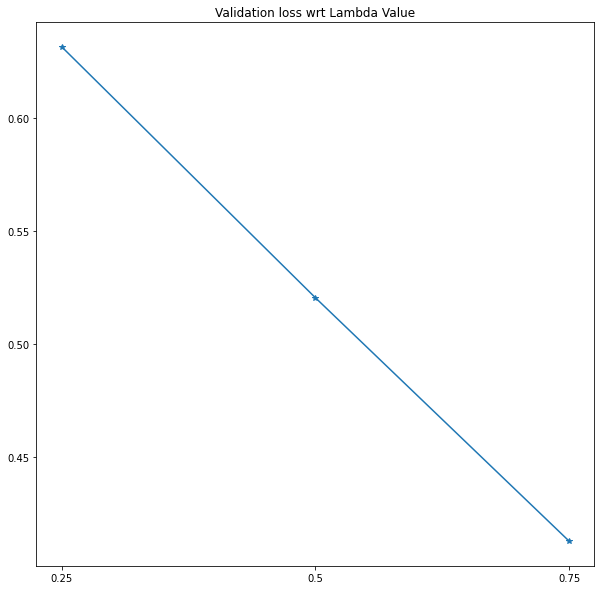

<Figure size 432x288 with 0 Axes>

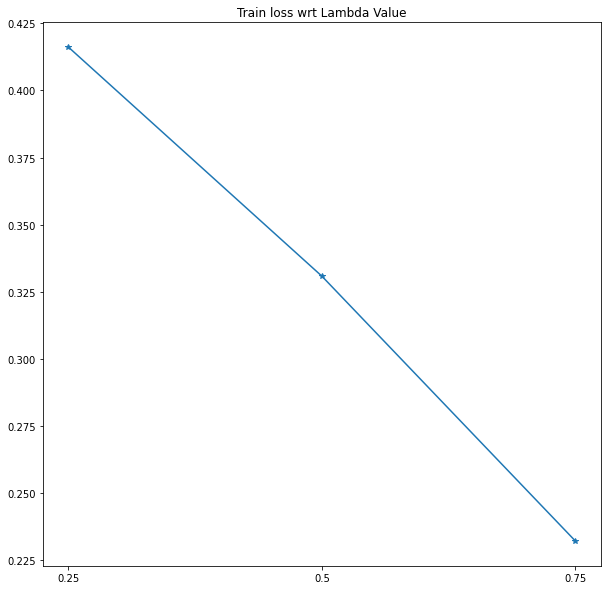

<Figure size 432x288 with 0 Axes>

In [10]:
avg_train_loss = []
avg_val_loss = []
since = time.time()
lamb_list = [0.25,0.5,0.75]

for weight in lamb_list:
    # Initialize the model for this run
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_ft = unet()

    # send model to device-cuda
    model_ft = model_ft.to(device)

    print('Lambda Value {}'.format(weight))
    criterion = SwitchLoss()
    optimizer = torch.optim.Adam(model_ft.parameters(), lr = 0.00005)
    
    loss_train = []
    loss_valid = []
    running_loss = 0.0
    running_loss1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Training
        for imgs, masks in training_generator:
            
            # Transfer to GPU
            imgs, masks = imgs.to(device), masks.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_ft(imgs)
            loss = criterion(outputs, masks, weight)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
        # print statistics
        epoch_loss = running_loss/len(training_generator)
        print('{} Loss: {:.4f} ' .format('Train', epoch_loss))
        loss_train.append(epoch_loss)
        running_loss = 0.0

        for imgs, masks in validation_generator:

            # Transfer to GPU
            imgs, masks = imgs.to(device), masks.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward  # backward and optimisation happen only in train phase!
            outputs = model_ft(imgs)
            loss = criterion(outputs, masks, weight)
            loss.backward()
            running_loss1 += loss.item()
        
        # print statistics
        epoch_loss = running_loss1/ len(validation_generator)
        print('{} Loss: {:.4f} ' .format('Validation', epoch_loss))
        loss_valid.append(epoch_loss)
        running_loss1 = 0.0
            
        time_elapsed1 = time.time() - since
        print('Time taken for one epoch {:.0f}m {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
    torch.save(model_ft.state_dict(), '/content/drive/My Drive/AML_assignments/model_switch' +str(weight) +'.pt')

    print('Time taken for one loop is {:.0f}m {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
    avg_train_loss.append(sum(loss_train)/len(loss_train))
    avg_val_loss.append(sum(loss_valid)/len(loss_valid))
        
print('Finished Training')
plt.figure(figsize=(10,10))
plt.title("Validation loss wrt Lambda Value") 
plt.plot(avg_val_loss, "*-")
plt.xticks(np.arange(3), ('0.25', '0.5', '0.75'))
plt.figure()

plt.figure(figsize=(10,10))
plt.title("Train loss wrt Lambda Value") 
plt.plot(avg_train_loss, "*-")
plt.xticks(np.arange(3), ('0.25', '0.5', '0.75'))
plt.figure()